In [3]:
%load_ext tensorboard

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
import time
import pandas as pd
import keras_tuner as kt
import tensorboard
from datetime import datetime
from packaging import version
from tensorflow.keras import regularizers


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
folder = pathlib.Path().resolve()
data_dir = str(folder / "data")

In [5]:
image_h = 180
image_w = 180
batch_s = 32

In [6]:
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split= 0.2,
  subset = "training",
  seed=123,
  image_size=(image_h, image_w),
  batch_size=batch_s)

# Le test_set
test_set = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_h, image_w),
  batch_size=batch_s)

Found 41405 files belonging to 5 classes.
Using 33124 files for training.
Found 41405 files belonging to 5 classes.
Using 8281 files for validation.


In [7]:
class_names = train_set.class_names
print(class_names)

['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


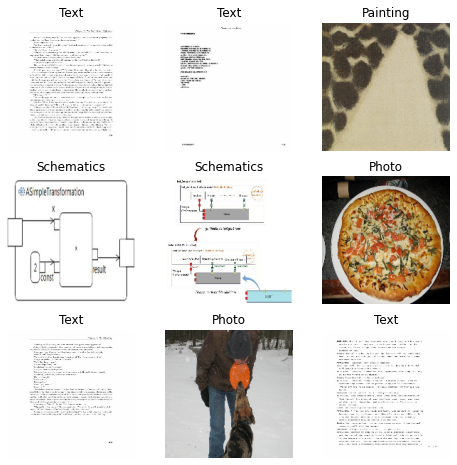

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax =  plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
print(type(train_set))
images, labels =  next(iter(train_set))
print(images.shape)
print(labels.shape)
print(labels)

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
(32, 180, 180, 3)
(32,)
tf.Tensor([4 0 0 4 4 2 2 2 2 1 1 2 4 3 4 0 2 2 2 2 4 1 1 2 2 4 0 1 4 2 2 2], shape=(32,), dtype=int32)


In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
num_classes = 5 # Nombre de classes et donc aussi nombre de neurones dans la dernière couche
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(32,  kernel_regularizer=regularizers.l2(0.0001), activation='relu'),
  tf.keras.layers.Dense(num_classes, activation = "softmax")
])

In [12]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

checkpoint_path = "training/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [13]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [24]:
epochs = 3

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True)

history = model.fit(
  train_set,
  callbacks=[cp_callback, tensorboard_callback],
  validation_data=test_set,
  epochs=epochs
)

Epoch 1/3
1036/1036 [==============================] - ETA: 0s - loss: 0.6670 - accuracy: 0.7115
Epoch 00001: saving model to training\cp-0001.ckpt
1036/1036 [==============================] - 411s 396ms/step - loss: 0.6670 - accuracy: 0.7115 - val_loss: 0.4388 - val_accuracy: 0.8163
Epoch 2/3
1036/1036 [==============================] - ETA: 0s - loss: 0.4047 - accuracy: 0.8320
Epoch 00002: saving model to training\cp-0002.ckpt
1036/1036 [==============================] - 390s 377ms/step - loss: 0.4047 - accuracy: 0.8320 - val_loss: 0.3713 - val_accuracy: 0.8470
Epoch 3/3
1036/1036 [==============================] - ETA: 0s - loss: 0.3471 - accuracy: 0.8583
Epoch 00003: saving model to training\cp-0003.ckpt
1036/1036 [==============================] - 385s 371ms/step - loss: 0.3471 - accuracy: 0.8583 - val_loss: 0.3430 - val_accuracy: 0.8627


In [14]:
# A run qu'en cas de non run du fit /!\
latest = tf.train.latest_checkpoint(checkpoint_dir)
# # Load the previously saved weights
model.load_weights(latest)

## Validation des données

In [ ]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(test_set, verbose=1) # verbose shows us how long there is to go
predictions

193/259 [=====================>........] - ETA: 6s

In [ ]:
unique_labels = np.unique(class_names)

# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_labels))
preds_df.head()

test_predictions = model.predict(test_set, verbose=1)

preds_df[list(unique_labels)] = test_predictions
preds_df.head()

In [ ]:
# Turn probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """

  return unique_labels[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])

In [ ]:
def get_pred_labels(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  labels=[]
    
  for item in prediction_probabilities:
    labels.append(np.argmax(item))
  #return unique_labels[np.argmax(prediction_probabilities)]
  return labels

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_labels(predictions)

In [ ]:
images_ = []
labels_ = []

# Loop through unbatched data

for image, label in test_set.unbatch().as_numpy_iterator():
  images_.append(image)
  labels_.append(label)

In [ ]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batch dataset of (image, label) Tensors and returns separate arrays of images and labels
  """
  images = []
  labels = []

  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    #labels.append(unique_labels[label])
    labels.append(label)

  return images,labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(test_set)
val_images[0], val_labels[0]

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image and remove ticks
  plt.imshow(image.astype("uint8"))
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color="green"
  else:
    color="red"

  # Change plot title to be predicted, probability of prediction and truth
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

In [ ]:
plot_pred(prediction_probabilities=predictions,
          labels=unique_labels[val_labels],
          images=val_images,
          n=457)

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-5:][::-1]
  # Find the top 10 prediction confidence value
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_labels[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)), 
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

In [ ]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=unique_labels[val_labels],
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=unique_labels[val_labels],
                 n=i+i_multiplier)
plt.tight_layout()
plt.show

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Autres mesures de performance

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import r2_score

In [ ]:
pred_label = get_pred_labels(predictions)

results = confusion_matrix(val_labels, pred_label)
print ('Confusion Matrix :')
print(results)
print ('Accuracy Score is',accuracy_score(val_labels, pred_label))
print ('Classification Report : ')
print (classification_report(val_labels, pred_label))

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix= results, display_labels= unique_labels[val_labels])
disp.plot()
plt.show()

In [ ]:
print ('R Squared =', r2_score(val_labels, pred_label))
print ('MAE =', mean_absolute_error(val_labels, pred_label))
print ('MSE =', mean_squared_error(val_labels, pred_label))

Le score F1 peut être interprété comme une moyenne harmonique de la précision et du rappel, où un score F1 atteint sa meilleure valeur à 1 et le pire score à 0. La contribution relative de la précision et du rappel au score F1 est égale. La formule du score F1 est : 

$$ F1 =  \frac{2 * (precision * recall)}{(precision + recall)}  $$

In [ ]:
print ('Calculez les métriques pour chaque étiquette et trouvez leur moyenne pondérée par support (le nombre d\'instances vraies pour chaque étiquette). Cela modifie la \"macro\" pour tenir compte du déséquilibre des étiquettes ; il peut en résulter un score F qui ne se situe pas entre la précision et le rappel.')
print ('F1 Score Weighted =', f1_score(val_labels, pred_label, average='weighted'))

print (' ')

print ('Calculez les métriques pour chaque étiquette et trouvez leur moyenne non pondérée. Cela ne prend pas en compte le déséquilibre des étiquettes.')
print ('F1 Score Macro =', f1_score(val_labels, pred_label, average='macro'))

print (' ')

print ('Calculez les métriques globalement en comptant le total des vrais positifs, des faux négatifs et des faux positifs.')
print ('F1 Score Macro =', f1_score(val_labels, pred_label, average='micro'))

In [ ]:
%tensorboard --logdir logs